In [1]:
import os
from skimage import io, img_as_float
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from osgeo import gdal

In [2]:
def sliding_window(img, step, window_size):
  # INPUT:
  # img = input image
  # step = the distance (in pixels, for both horizontal and vertical direction) 
  # between 2 windows
  # window_size = size of the sliding window, format: (pixels(y-axis),pixels(x-axis))
	
  # OUTPUT: (x,y,window)
  # x,y: the coordinates of the top left corner of the current window (in pixels) 
  # in the coordinate system of "img".
  # window: the current window, size = (window_size)

	for y in range(0, img.shape[0], step):
		for x in range(0, img.shape[1], step):
			yield (x, y, img[y:y + window_size[1], x:x + window_size[0]])

In [3]:
def read_modis(in_file):
  # This function is for reading modis file in format "x.hdf" contained in 
  # in_file parameter.
  # INPUT: 
  # in_file: path to hdf file
  # to be completed if we need more stuffs

  # OUTPUT:
  # LST_K_day and LST_K_night: Day and Night LST image arrays
  # cols, rows: numbers of pixels alongs x,y axes of each raster
  # projection: projection information
  # geotransform: georeferencing information
  ## georef format = (x-coor top left pixel,resX,0,y-coor top left pixel,rexY,0)
  # to be completed if we need more information (georeference,bands,etc.)

  # open dataset Day
  dataset = gdal.Open(in_file,gdal.GA_ReadOnly)
  subdataset =  gdal.Open(dataset.GetSubDatasets()[0][0], gdal.GA_ReadOnly)

  cols =subdataset.RasterXSize
  rows = subdataset.RasterYSize
  projection = subdataset.GetProjection()
  geotransform = subdataset.GetGeoTransform()

  # Coordinates of top left pixel of the image (Lat, Lon)
  # coords=np.asarray((geotransform[0],geotransform[3]))

  # We read the Image as an array
  band = subdataset.GetRasterBand(1)
  LST_raw = band.ReadAsArray(0, 0, cols, rows).astype(np.float)
  # bandtype = gdal.GetDataTypeName(band.DataType)

  # To convert LST MODIS units to Kelvin
  LST_K_day=0.02*LST_raw

  # open dataset Night
  dataset = gdal.Open(in_file,gdal.GA_ReadOnly)
  subdataset =  gdal.Open(dataset.GetSubDatasets()[4][0], gdal.GA_ReadOnly)

  # We read the Image as an array
  band = subdataset.GetRasterBand(1)
  LST_raw = band.ReadAsArray(0, 0, cols, rows).astype(np.float)
  # bandtype = gdal.GetDataTypeName(band.DataType)

  # To convert LST MODIS units to Kelvin
  LST_K_night=0.02*LST_raw

  return LST_K_day, LST_K_night, cols, rows, projection, geotransform

In [4]:
def save_tif(out_file, LST_K_day, LST_K_night, cols, rows, projection, geotransform):
  # INPUT:
  # out_file: directory + name of output tif file (e.g a/b/c/MOD11A1.tif)
  # LST_K_day, LST_K_night, cols, rows, projection, geotransform: read read_modis

  # OUTPUT:
  # A .tif file having 2 bands(1 for day, 1 for night)

  bands = 2
  day_night_imgs = np.zeros((2,LST_K_day.shape[0],LST_K_day.shape[1]))
  day_night_imgs[0,:,:]= LST_K_day
  day_night_imgs[1,:,:]= LST_K_night

  driver = gdal.GetDriverByName("GTiff")
  outDs = driver.Create(out_file, cols, rows, bands, gdal.GDT_Float32) 
  outDs.SetProjection(projection)
  outDs.SetGeoTransform(geotransform) 

  for i in range(1,bands+1):
      outBand = outDs.GetRasterBand(i)
      outBand.WriteArray(day_night_imgs[i-1,:,:])
      outDs.FlushCache()

In [5]:
def read_tif(in_file):
  # Similar to read_modis but this function is for reading output .tif file from
  # save_tif()

  dataset =  gdal.Open(in_file, gdal.GA_ReadOnly)

  cols =dataset.RasterXSize
  rows = dataset.RasterYSize
  projection = dataset.GetProjection()
  geotransform = dataset.GetGeoTransform()

  # Coordinates of top left pixel of the image (Lat, Lon)
  coords=np.asarray((geotransform[0],geotransform[3]))

  # Open dataset Day as np.array()
  band = dataset.GetRasterBand(1)
  LST_K_day = band.ReadAsArray().astype(np.float)
  bandtype = gdal.GetDataTypeName(band.DataType)

  # open dataset Night as np.array()
  band = dataset.GetRasterBand(2)
  LST_K_night = band.ReadAsArray().astype(np.float)
  bandtype = gdal.GetDataTypeName(band.DataType)

  return LST_K_day,LST_K_night,cols,rows,projection,geotransform

In [6]:
def crop_modis(img_path,dir,step=64,size=(64,64)):
  # INPUT:
  # img_path = input image path to be cropped | or hdf file path ("/a/b/c.hdf")
  # dir = directory for saving cropped images
  # step, size: parameters of "sliding_window()"

  # OUTPUT: images cropped from the image in img_path, saved to dir

  if Path(img_path).suffix == ".hdf":
    img_day, img_night, cols, rows, projection, geotransform = read_modis(img_path)

    img_days = []
    img_nights = []
    img_cropped_names = []
    geotransform2s = []
    cols2, rows2 = size

    if img_day is None or img_night is None:
      print("Cannot handle this MODIS file: ", img_path, ". Please check it again")
    else:
      # For day image
      win_count = 0
      for (x,y,window) in sliding_window(img_day, step, size):
        if window.shape[0] != size[0] or window.shape[1] != size[1]:
          continue

        img_cropped_name = Path(img_path).stem + ".%d"%win_count + ".tif"
        img_cropped = window
        geotransform2 = np.asarray(geotransform)
        geotransform2[0] = geotransform[0]+x*geotransform[1] # 1st coordinate of top left pixel of the image 
        geotransform2[3] = geotransform[3]+y*geotransform[5] # 2nd coordinate of top left pixel of the image
        geotransform2=tuple(geotransform2)

        img_cropped_names.append(img_cropped_name)
        img_days.append(img_cropped)
        geotransform2s.append(geotransform2)
        
        win_count += 1
      print("Number of cropped day images", win_count)

      # For night image
      win_count = 0
      for (x,y,window) in sliding_window(img_night, step, size):
        if window.shape[0] != size[0] or window.shape[1] != size[1]:
          continue
        # save_path = os.path.join(dir,img_cropped_name)
        img_cropped = window
        # np.save(save_path,img_cropped)
        img_nights.append(img_cropped)
        win_count += 1
      print("Number of cropped night images", win_count)
      
      # Save images and metadata into .tif file
      for i in range(len(img_cropped_names)):
        save_path = os.path.join(dir,img_cropped_names[i])
        save_tif(save_path, img_days[i], img_nights[i], cols2, rows2, projection, geotransform2s[i])

In [13]:
def cloud_sea_eliminate(dir):
  # INPUT
  # dir: the directory containing cropped TIF file from which we want to eliminate 
  # the ones having cloud and sea

  # OUTPUT
  # there is not any output, just the images containing cloud or sea pixels (>15% the number of pixels)  
  # will be eliminated from the directory

  for item in Path(dir).iterdir():
    if item.is_file() and Path(item).suffix == ".tif":
      LST_K_day, LST_K_night, cols, rows, projection, geotransform = read_tif(str(item))
      num_px = cols*rows
      thres = 0.15 # Threshold: maximum number of sea/cloud pixels
      if len(LST_K_day[LST_K_day==0.0]) > thres*num_px or len(LST_K_night[LST_K_night==0.0]) > thres*num_px:
        os.remove(item)


In [8]:
def image_crop(img_path,dir,step=64,size=(64,64)):
  # INPUT:
  # img_path = input image path to be cropped | or hdf file path ("/a/b/c.hdf")
  # dir = directory for saving cropped images
  # step, size: parameters of "sliding_window()"

  # OUTPUT: images cropped from the image in img_path, saved to dir

  if Path(img_path).suffix == ".hdf":
    img_day, img_night = read_modis(img_path)
    if img_day is None or img_night is None:
      print("Cannot handle this MODIS file: ", img_path, ". Please check it again")
    else:
      # For day image
      win_count = 0
      for (x,y,window) in sliding_window(img_day, step, size):
        if window.shape[0] != size[0] or window.shape[1] != size[1]:
          continue
        # img_cropped_name = os.path.split(img_path)[1].split(".")[0] + "_%d"%win_count + ".png"
        img_cropped_name = Path(img_path).stem + ".day.%d"%win_count
        save_path = os.path.join(dir,img_cropped_name)
        # save_path = dir + "/" + img_cropped_name
        img_cropped = window
        # io.imsave(save_path,img_cropped)
        np.save(save_path,img_cropped)
        win_count += 1
      print("Number of cropped day images", win_count)

      # For night image
      win_count = 0
      for (x,y,window) in sliding_window(img_night, step, size):
        if window.shape[0] != size[0] or window.shape[1] != size[1]:
          continue
        # img_cropped_name = os.path.split(img_path)[1].split(".")[0] + "_%d"%win_count + ".png"
        img_cropped_name = Path(img_path).stem + ".night.%d"%win_count
        save_path = os.path.join(dir,img_cropped_name)
        # save_path = dir + "/" + img_cropped_name
        img_cropped = window
        # io.imsave(save_path,img_cropped)
        np.save(save_path,img_cropped)
        win_count += 1
      print("Number of cropped night images", win_count)

  else:
    img = io.imread(img_path)
    if img is None:
      print("This is not an image")
    else:
      win_count = 0
      for (x,y,window) in sliding_window(img, step, size):
        if window.shape[0] != size[0] or window.shape[1] != size[1]:
          continue
        # img_cropped_name = os.path.split(img_path)[1].split(".")[0] + "_%d"%win_count + ".png"
        img_cropped_name = Path(img_path).stem + ".%d"%win_count + ".png"
        save_path = os.path.join(dir,img_cropped_name)
        # save_path = dir + "/" + img_cropped_name
        img_cropped = window
        io.imsave(save_path,img_cropped)
        win_count += 1
      print("Number of cropped images", win_count)
    

In [ ]:
# %cd /content/drive/MyDrive/IMT 3eme annee/Project S5

In [ ]:
in_file = "MOD11A1.A2021274.h18v04.061.2021278094039.hdf"
# LST_K_day, LST_K_night = read_modis(in_file)

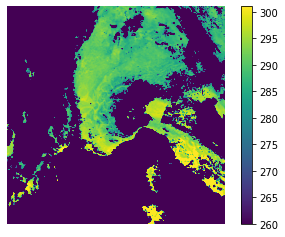

In [ ]:
img = img_as_float(io.imread('test-img.png'))
# plt.figure(figsize=(5, 5))
plt.axis('off')
plt.imshow(LST_K_day)
plt.clim(260,301)
plt.colorbar()
plt.show()
# print(LST_K_day.shape)

### Test sliding_window()

0 0


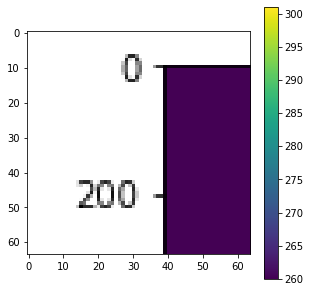

64 0


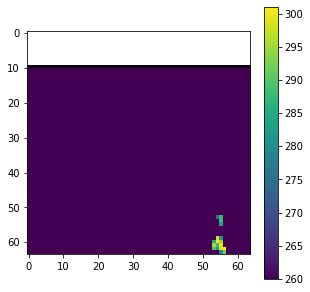

128 0


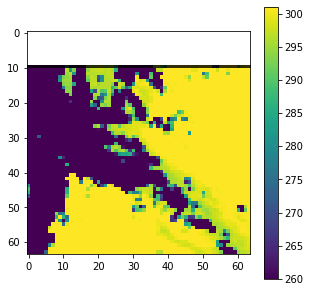

192 0


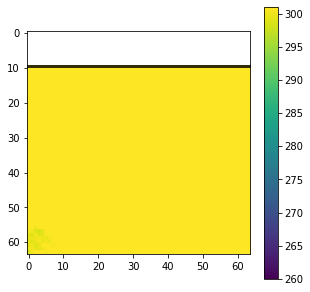

0 64


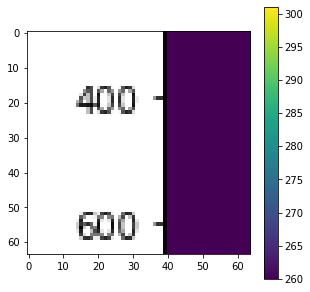

64 64


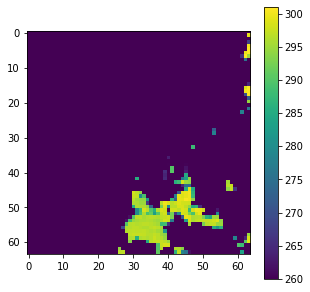

128 64


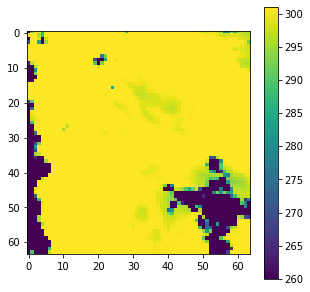

192 64


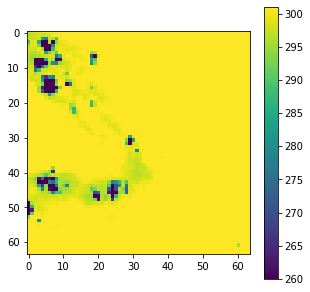

0 128


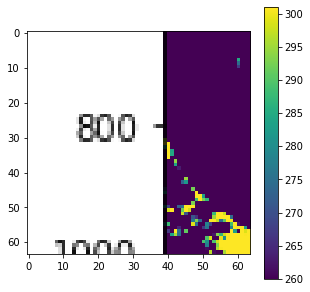

64 128


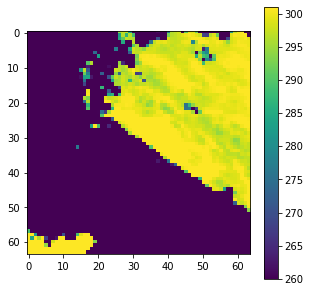

128 128


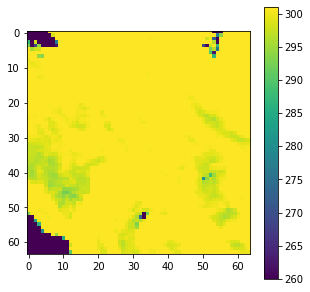

192 128


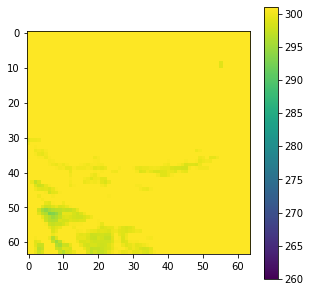

In [ ]:
img1 = io.imread('test-img.png')
step = 64
count=0
(winW, winH) = (64,64)
for (x,y,window) in sliding_window(img1, step=step, window_size=(winW, winH)):
  if window.shape[0] != winH or window.shape[1] != winW:
			continue
  print(x,y)
  count += 1
  plt.figure(figsize=(5, 5))
  plt.imshow(window)
  plt.clim(260,301)
  plt.colorbar()
  plt.show()

### Test image_crop()

In [11]:
image_crop(in_file,"",64,(64,64))

NameError: ignored

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


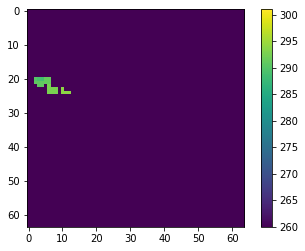

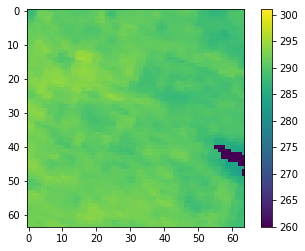

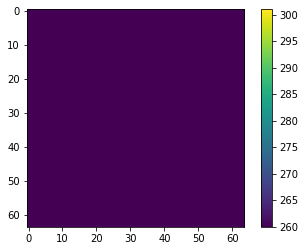

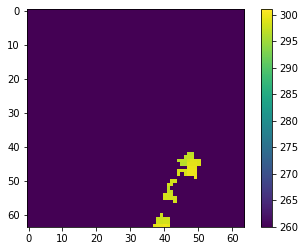

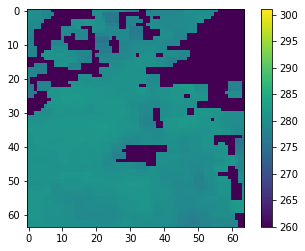

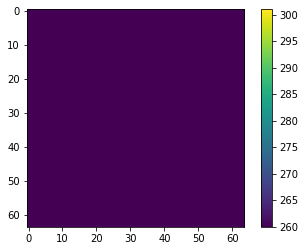

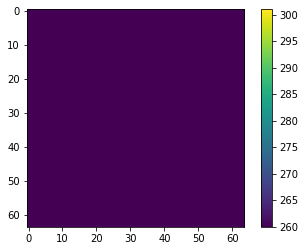

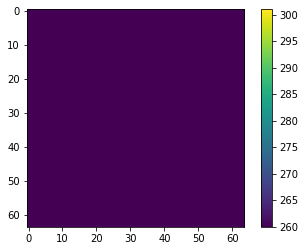

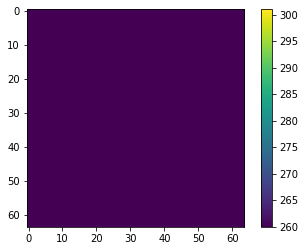

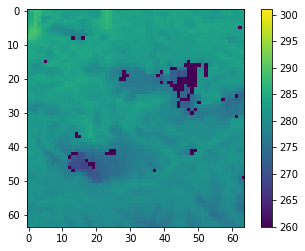

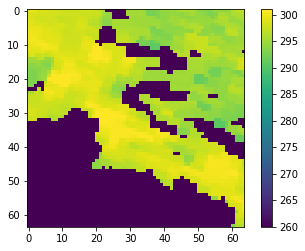

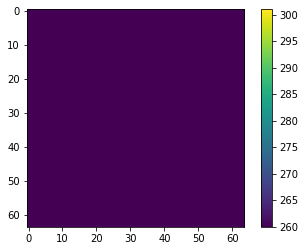

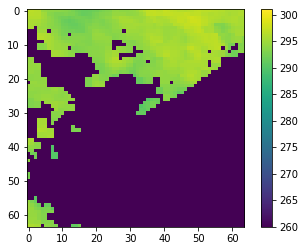

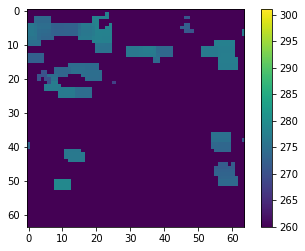

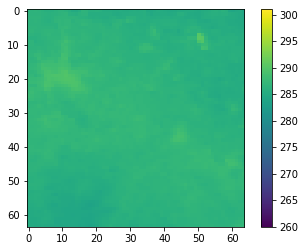

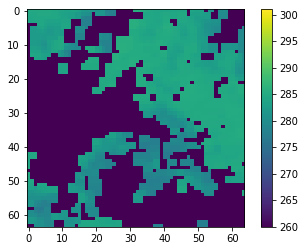

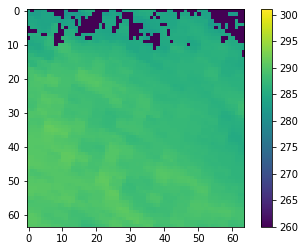

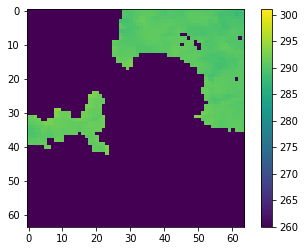

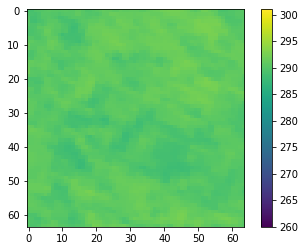

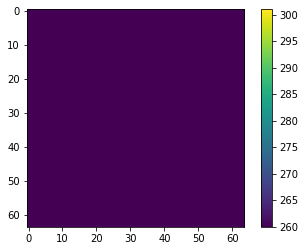

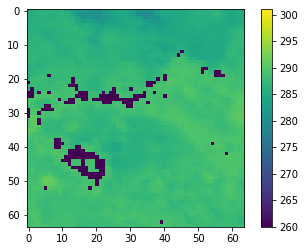

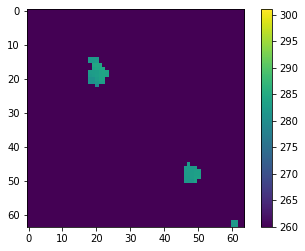

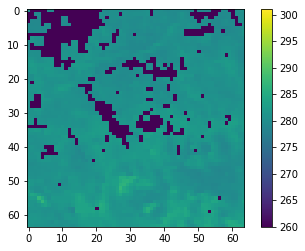

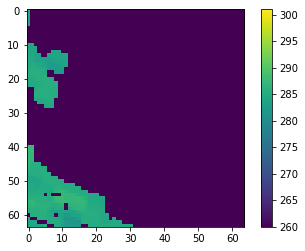

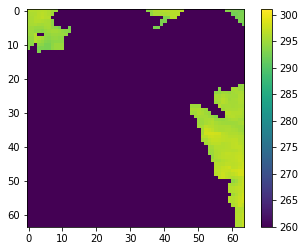

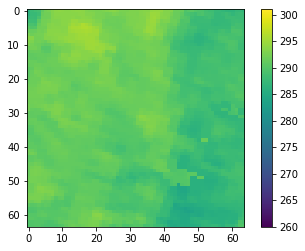

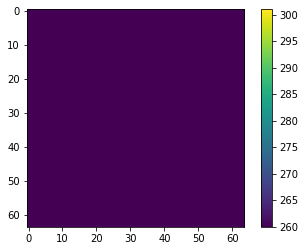

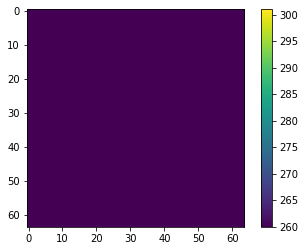

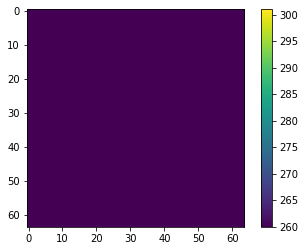

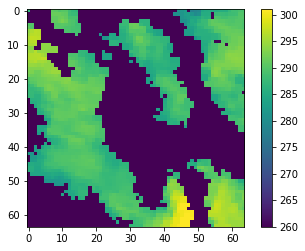

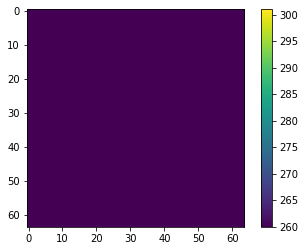

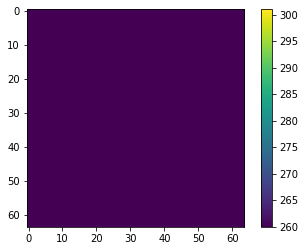

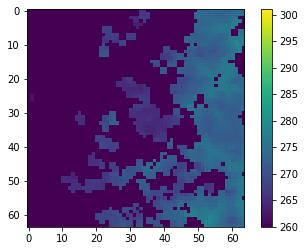

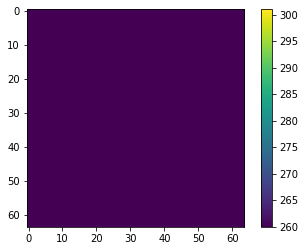

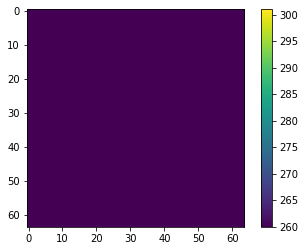

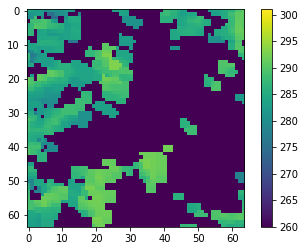

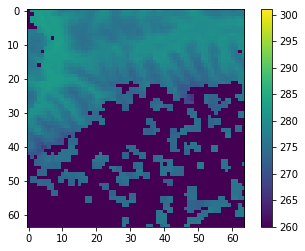

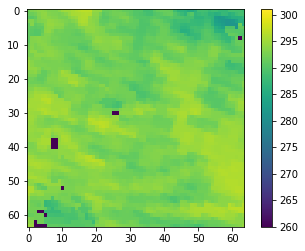

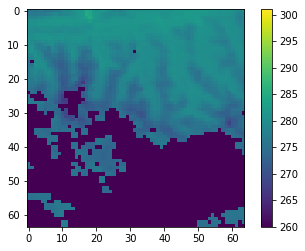

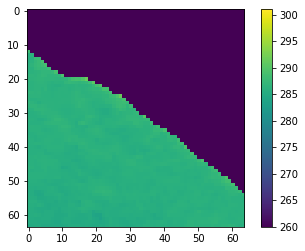

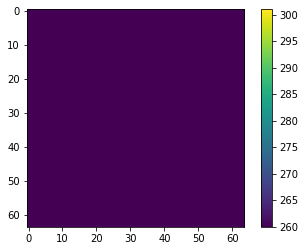

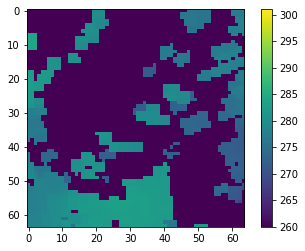

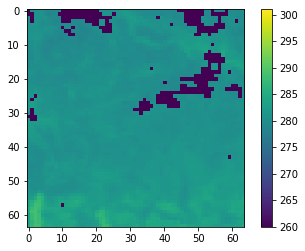

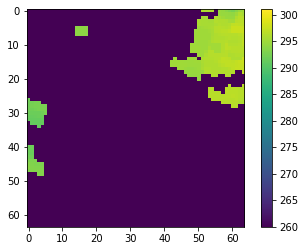

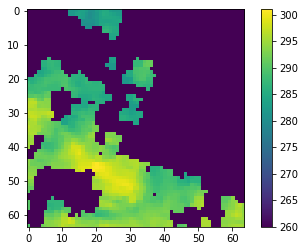

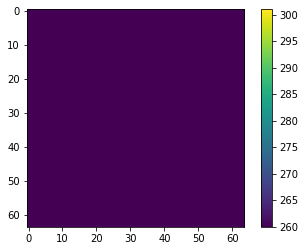

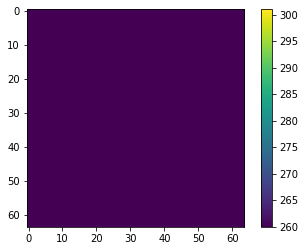

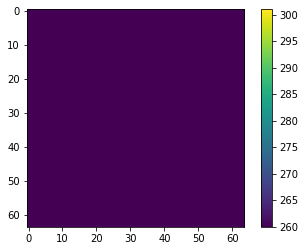

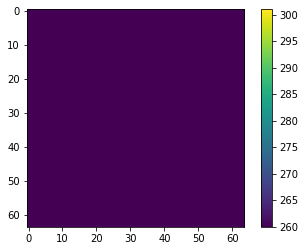

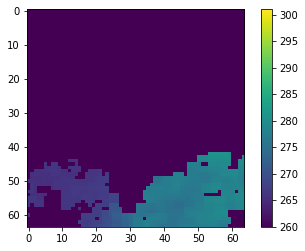

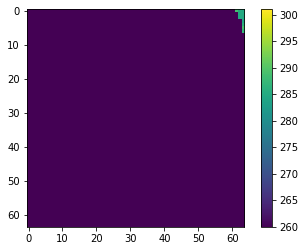

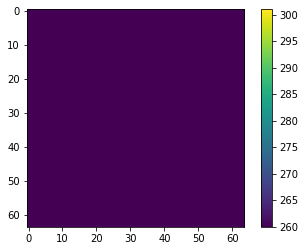

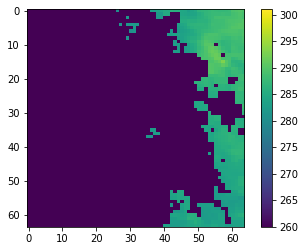

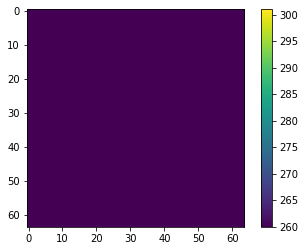

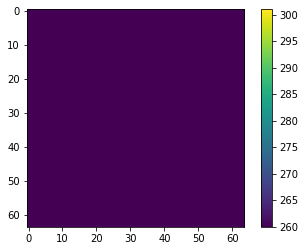

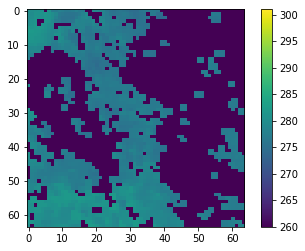

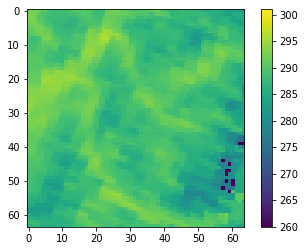

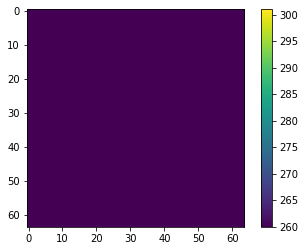

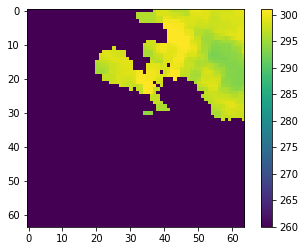

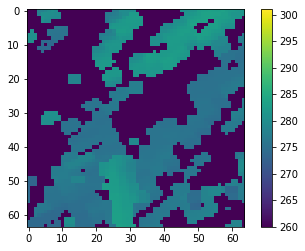

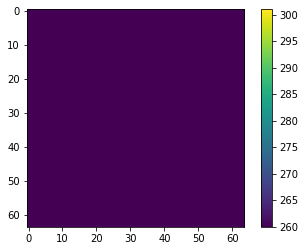

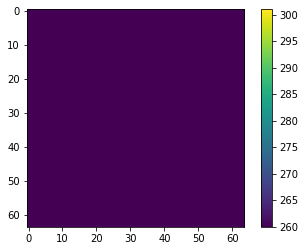

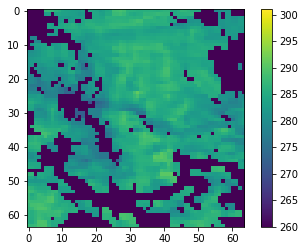

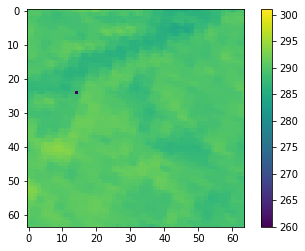

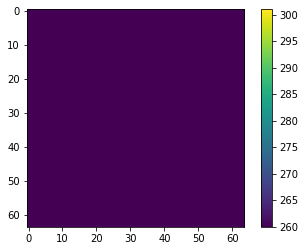

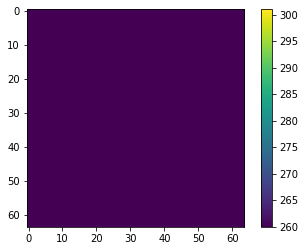

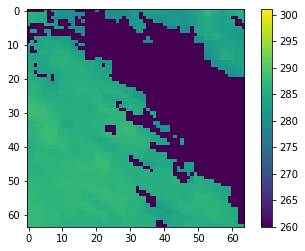

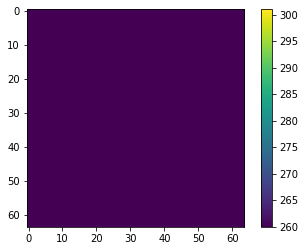

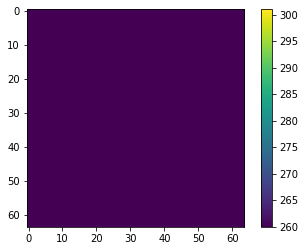

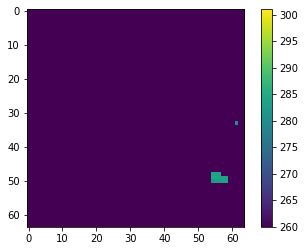

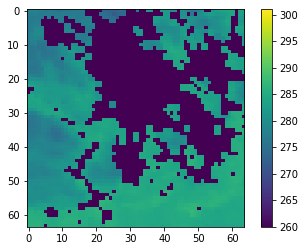

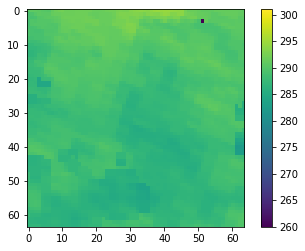

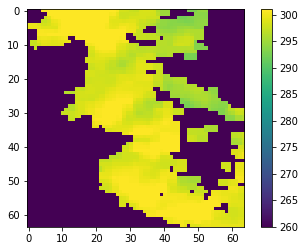

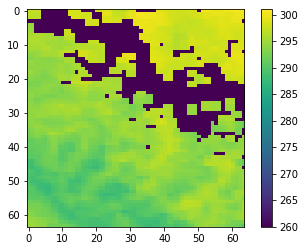

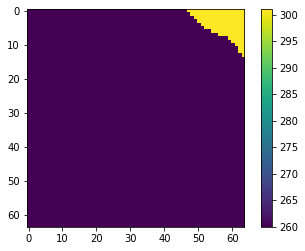

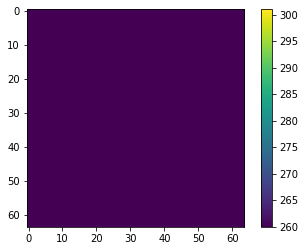

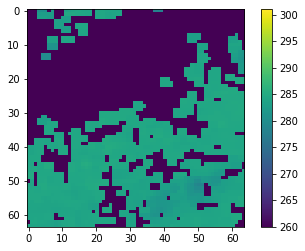

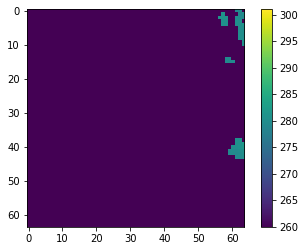

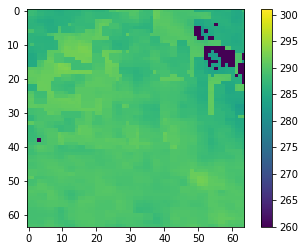

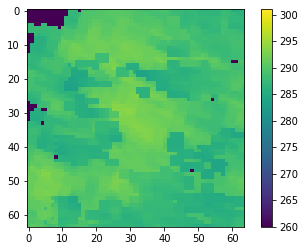

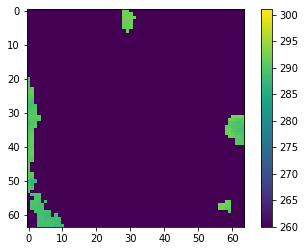

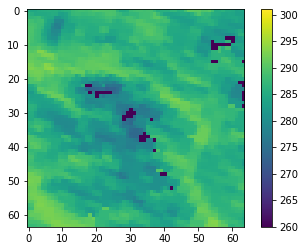

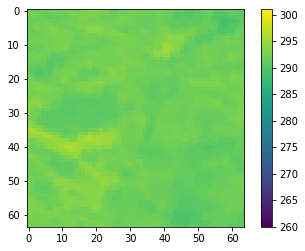

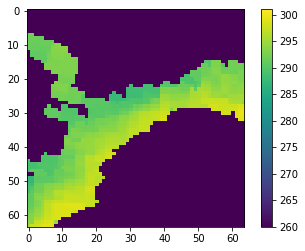

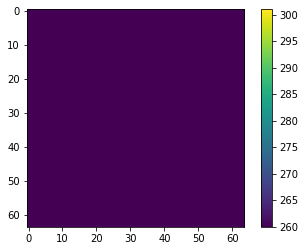

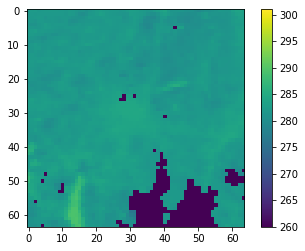

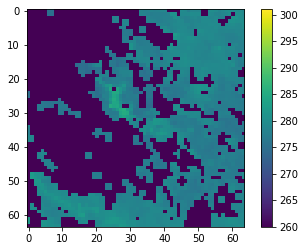

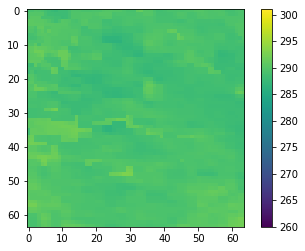

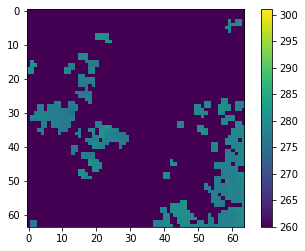

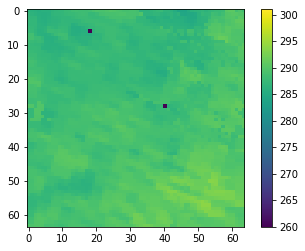

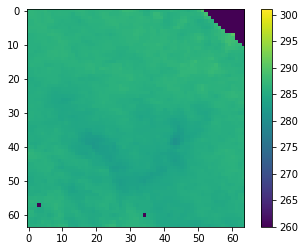

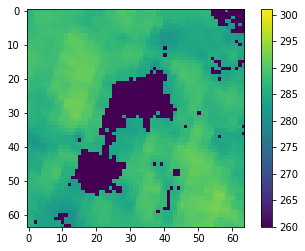

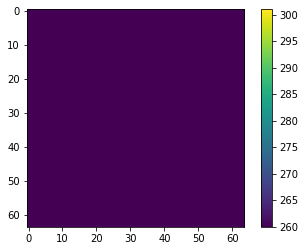

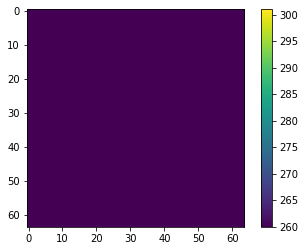

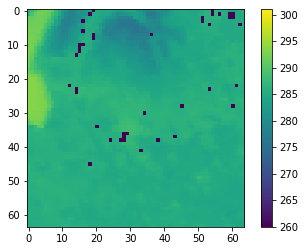

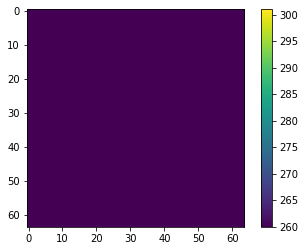

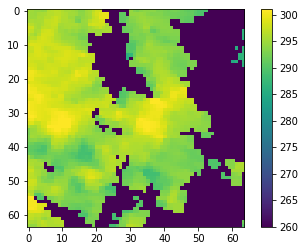

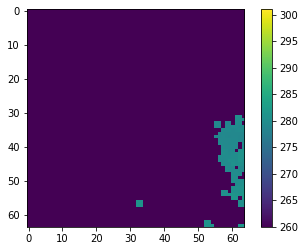

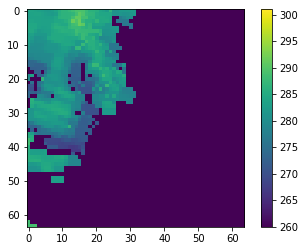

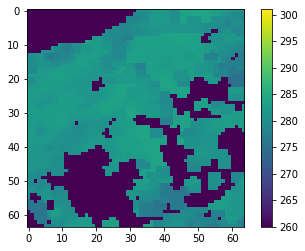

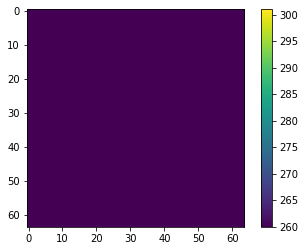

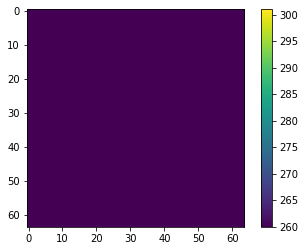

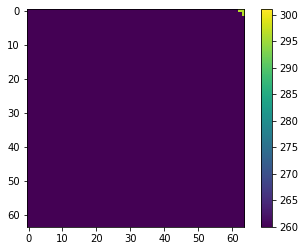

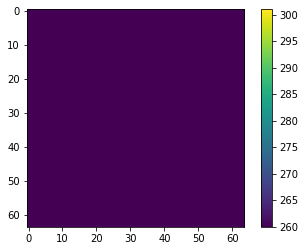

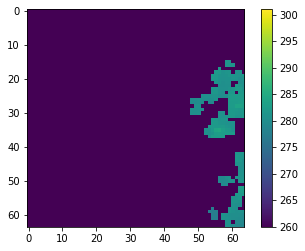

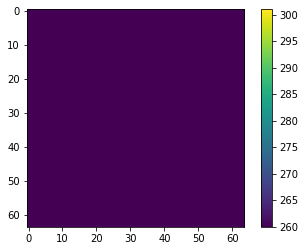

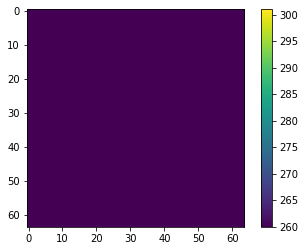

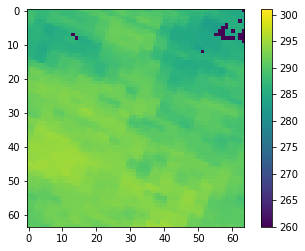

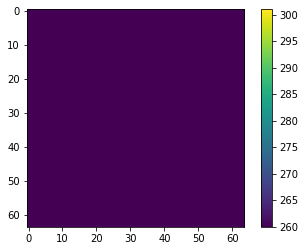

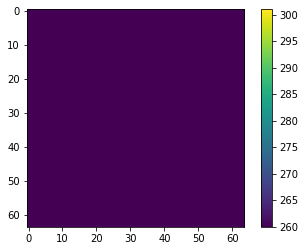

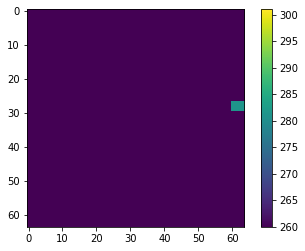

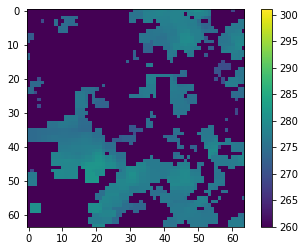

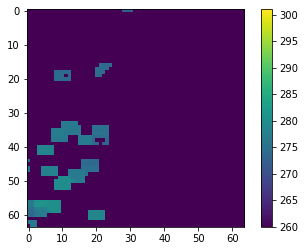

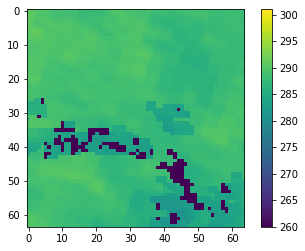

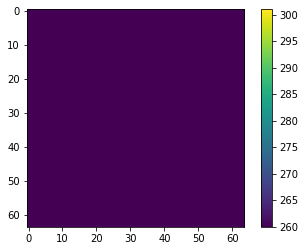

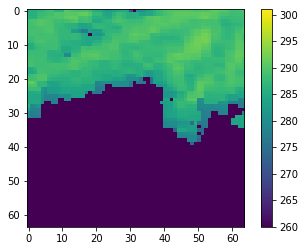

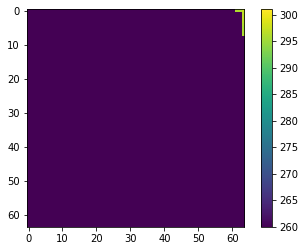

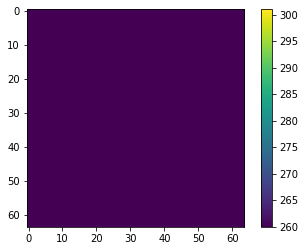

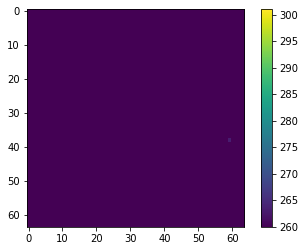

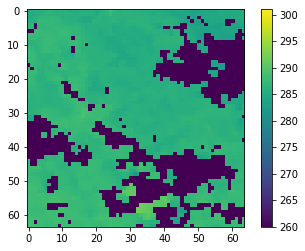

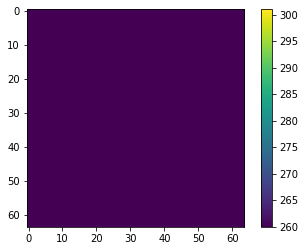

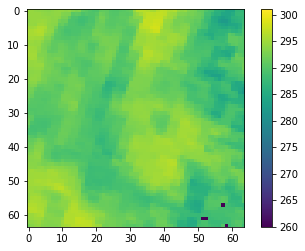

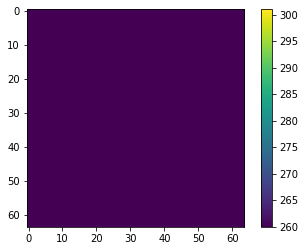

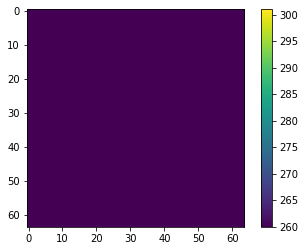

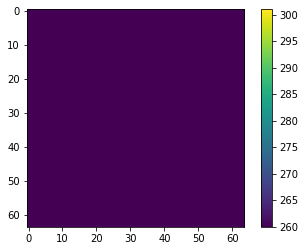

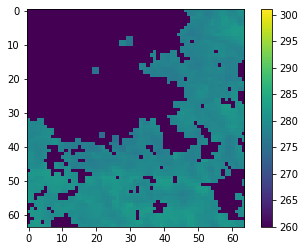

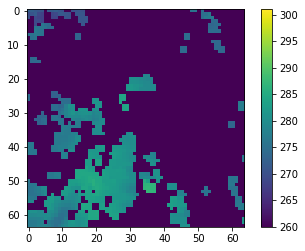

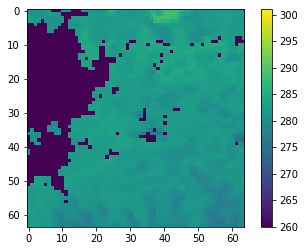

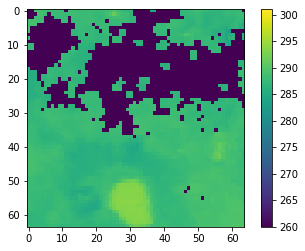

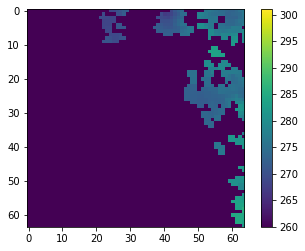

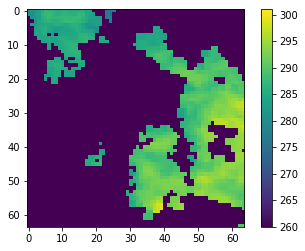

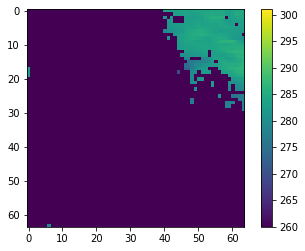

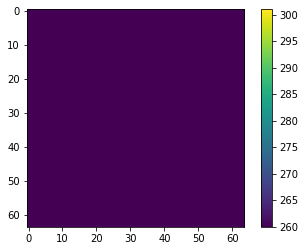

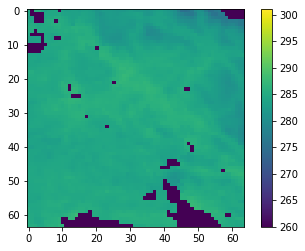

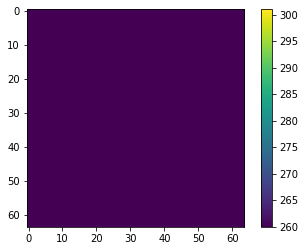

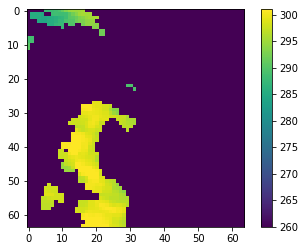

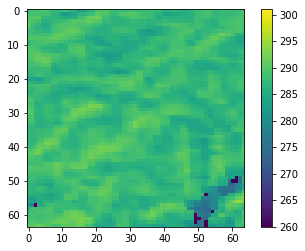

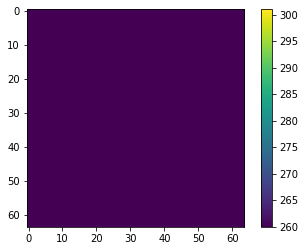

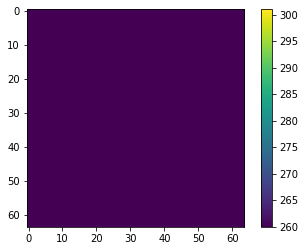

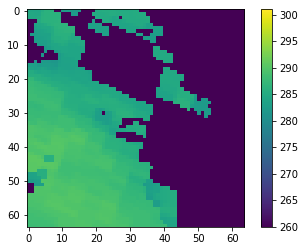

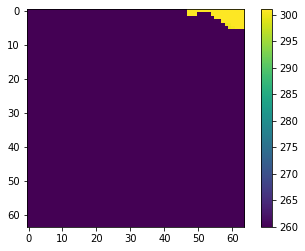

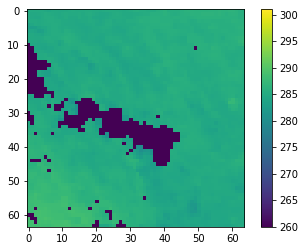

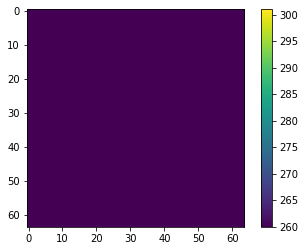

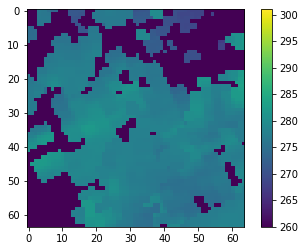

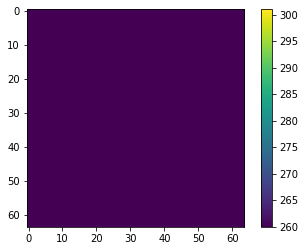

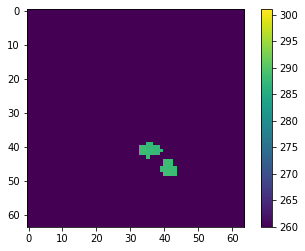

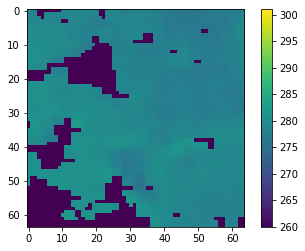

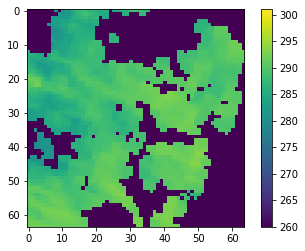

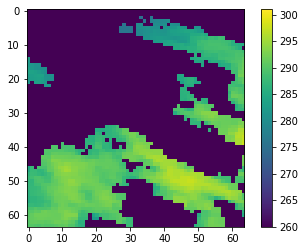

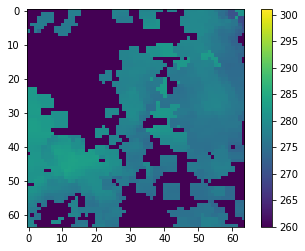

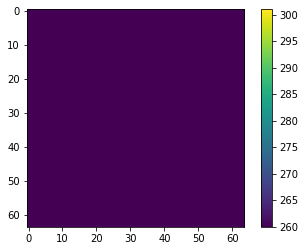

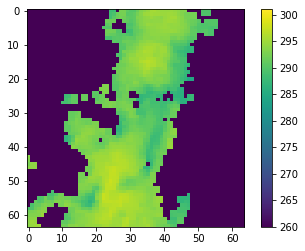

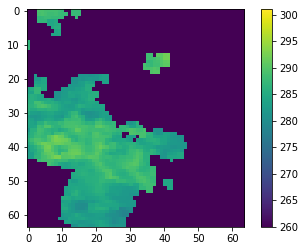

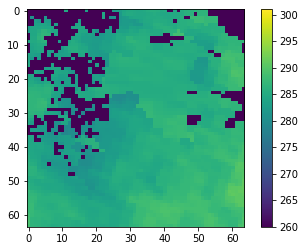

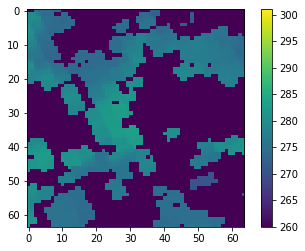

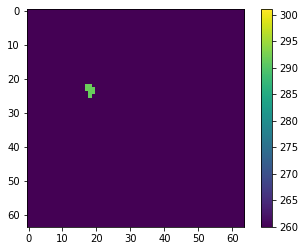

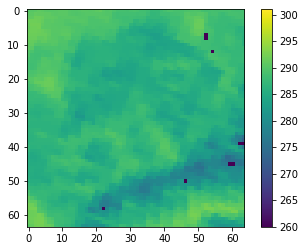

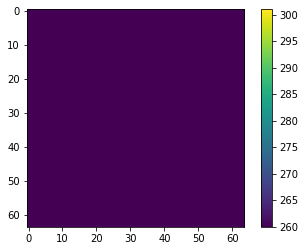

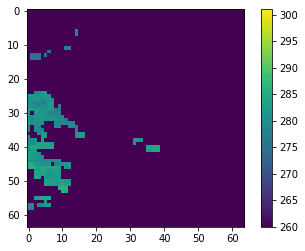

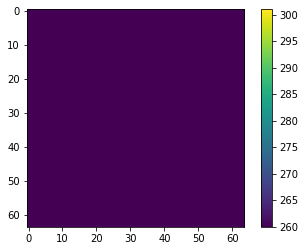

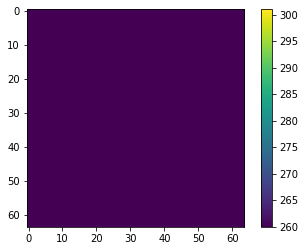

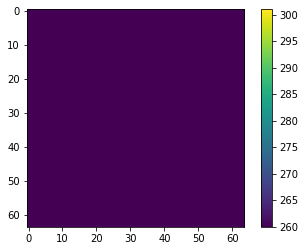

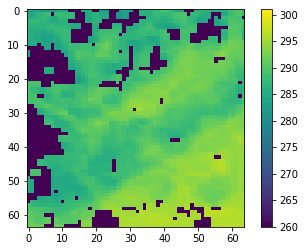

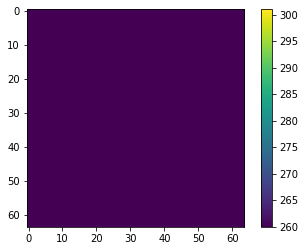

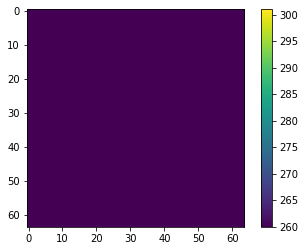

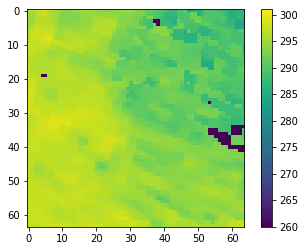

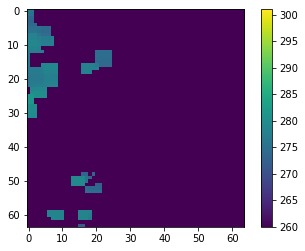

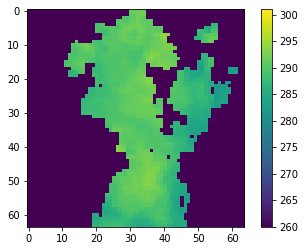

Error in callback <function flush_figures at 0x7faf1bf69320> (for post_execute):


KeyboardInterrupt: ignored

In [ ]:
for item in Path("/content").iterdir():
  if item.is_file() and Path(item).suffix == ".npy":
    LST_K = np.load(item)
    plt.figure()
    plt.imshow(LST_K)
    plt.clim(260,301)
    plt.colorbar()

# Test save_modis()

In [ ]:
in_file = "MOD11A1.A2021274.h18v04.061.2021278094039.hdf"
out_file = "modis_test.tif"
LST_K_day, LST_K_night, cols, rows, projection, geotransform = read_modis(in_file)
save_modis(out_file,LST_K_day, LST_K_night, cols, rows, projection, geotransform)

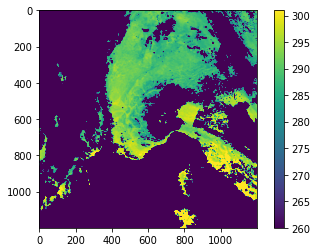

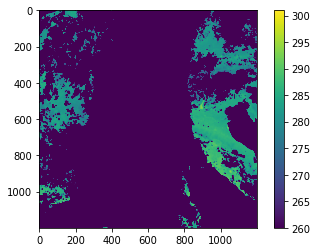

In [ ]:
LST_K_day_, LST_K_night_, cols_, rows_, projection_, geotransform_ = read_tif(out_file)
plt.figure()
plt.imshow(LST_K_day_)
plt.clim(260,301)
plt.colorbar()
plt.show()
plt.figure()
plt.imshow(LST_K_night_)
plt.clim(260,301)
plt.colorbar()
plt.show()

# Test crop_modis()

In [12]:
in_file = "MOD11A1.A2021274.h18v04.061.2021278094039.hdf"
LST_K_day, LST_K_night, cols, rows, projection, geotransform=read_modis(in_file)
crop_modis(in_file,"",64,(64,64))

Number of cropped day images 324
Number of cropped night images 324


In [9]:
LST_K_day_, LST_K_night_, cols_, rows_, projection_, geotransform_ = read_tif("MOD11A1.A2021274.h18v04.061.2021278094039.100.tif")

In [ ]:
geotransform, geotransform_

((0.0, 926.6254331391667, 0.0, 5559752.598833, 0.0, -926.625433139167),
 (593040.2772090667,
  926.6254331391667,
  0.0,
  5263232.460228467,
  0.0,
  -926.625433139167))

/content/MOD11A1.A2021274.h18v04.061.2021278094039.15.tif
/content/MOD11A1.A2021274.h18v04.061.2021278094039.8.tif
/content/MOD11A1.A2021274.h18v04.061.2021278094039.2.tif
/content/MOD11A1.A2021274.h18v04.061.2021278094039.3.tif
/content/MOD11A1.A2021274.h18v04.061.2021278094039.14.tif
/content/MOD11A1.A2021274.h18v04.061.2021278094039.4.tif
/content/MOD11A1.A2021274.h18v04.061.2021278094039.7.tif
/content/MOD11A1.A2021274.h18v04.061.2021278094039.10.tif
/content/MOD11A1.A2021274.h18v04.061.2021278094039.13.tif
/content/MOD11A1.A2021274.h18v04.061.2021278094039.0.tif
/content/MOD11A1.A2021274.h18v04.061.2021278094039.5.tif
/content/MOD11A1.A2021274.h18v04.061.2021278094039.1.tif
/content/MOD11A1.A2021274.h18v04.061.2021278094039.9.tif
/content/MOD11A1.A2021274.h18v04.061.2021278094039.12.tif
/content/MOD11A1.A2021274.h18v04.061.2021278094039.11.tif
/content/MOD11A1.A2021274.h18v04.061.2021278094039.6.tif


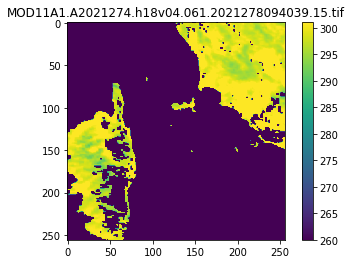

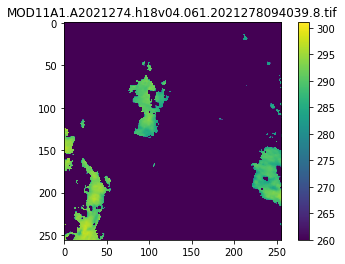

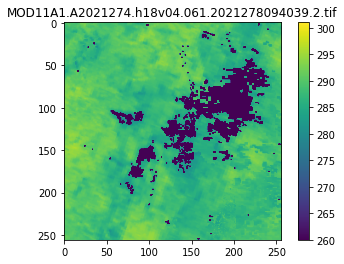

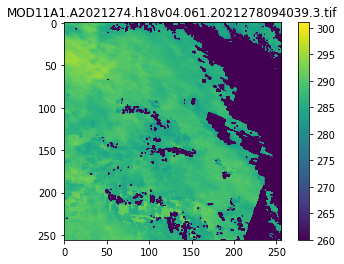

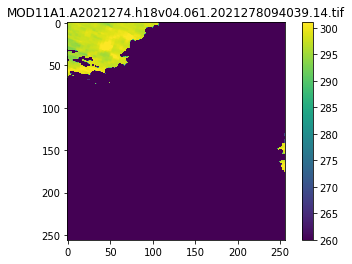

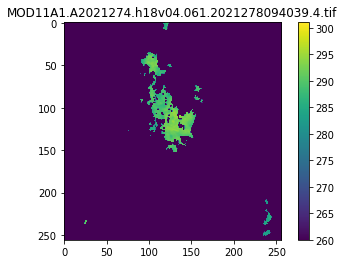

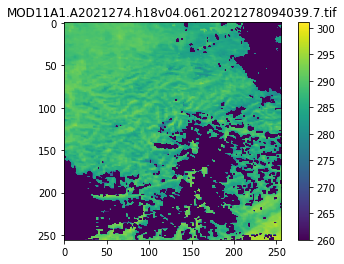

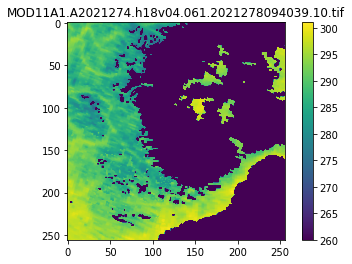

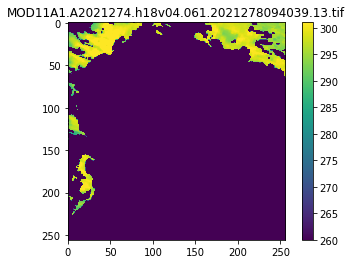

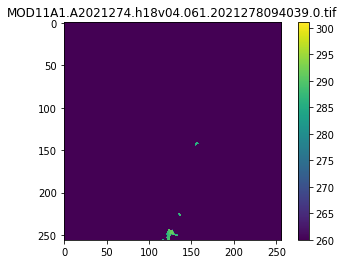

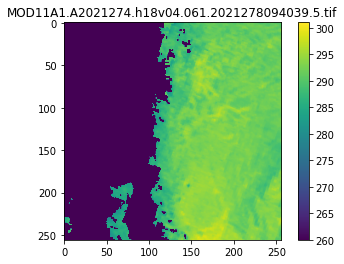

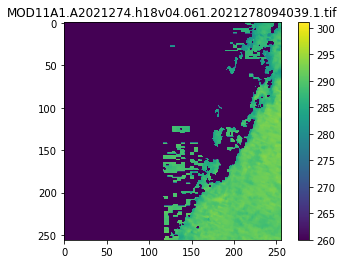

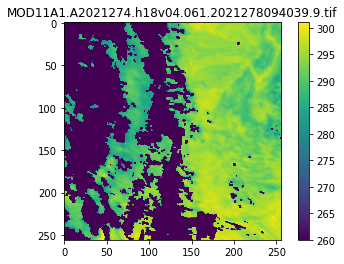

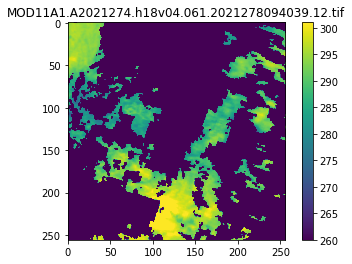

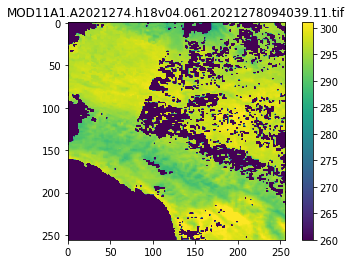

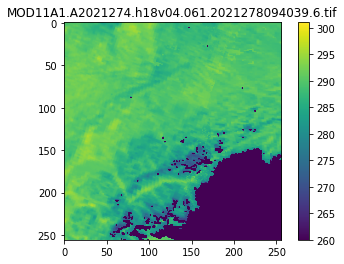

In [10]:
sum = 0
for item in Path("/content").iterdir():
  if item.is_file() and Path(item).suffix == ".tif":
    print(str(item))
    LST_K_day_, LST_K_night_, cols_, rows_, projection_, geotransform_ = read_tif(str(item))
    plt.figure()
    plt.imshow(LST_K_day_)
    plt.clim(260,301)
    plt.colorbar()
    plt.title(Path(item).name)


# Test cloud_sea_eliminate()

In [14]:
cloud_sea_eliminate("/content")

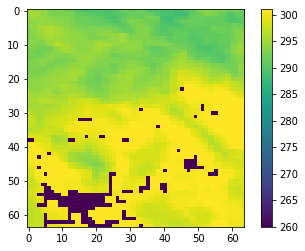

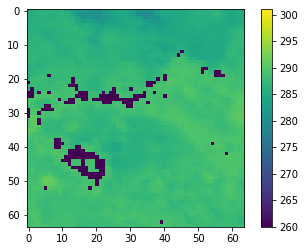

In [24]:
LST_K_day_, LST_K_night_, cols_, rows_, projection_, geotransform_ = read_tif("MOD11A1.A2021274.h18v04.061.2021278094039.212.tif")
plt.figure()
plt.imshow(LST_K_day_)
plt.clim(260,301)
plt.colorbar()
# plt.title(Path(item).name)
plt.figure()
plt.imshow(LST_K_night_)
plt.clim(260,301)
plt.colorbar()

In [25]:
len(LST_K_day_[LST_K_day_==0]), len(LST_K_night_[LST_K_night_==0])

(210, 176)